**Imports**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Pulling data from google drive**

In [2]:
data = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11], index_col=[0], parse_dates=[0])
data.head()

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [3]:
data = data.reset_index().rename(columns = {'timestamp':'ds'})
data = data.rename(columns={data.columns[1]:'y'})
data.head()

,ds,y
0,2018-01-01 05:00:00,0.660
1,2018-01-01 06:00:00,0.660
2,2018-01-01 07:00:00,0.615
3,2018-01-01 08:00:00,0.570
4,2018-01-01 09:00:00,0.570


In [4]:
data['y'] = np.log(data['y'])
data.head()

,ds,y
0,2018-01-01 05:00:00,-0.415515
1,2018-01-01 06:00:00,-0.415515
2,2018-01-01 07:00:00,-0.486133
3,2018-01-01 08:00:00,-0.562119
4,2018-01-01 09:00:00,-0.562119


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3xbppsub/6oj_aiow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3xbppsub/vpvf72jx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13635', 'data', 'file=/tmp/tmp3xbppsub/6oj_aiow.json', 'init=/tmp/tmp3xbppsub/vpvf72jx.json', 'output', 'file=/tmp/tmp3xbppsub/prophet_modelatxs4ys0/prophet_model-20230811150132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:01:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:01:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


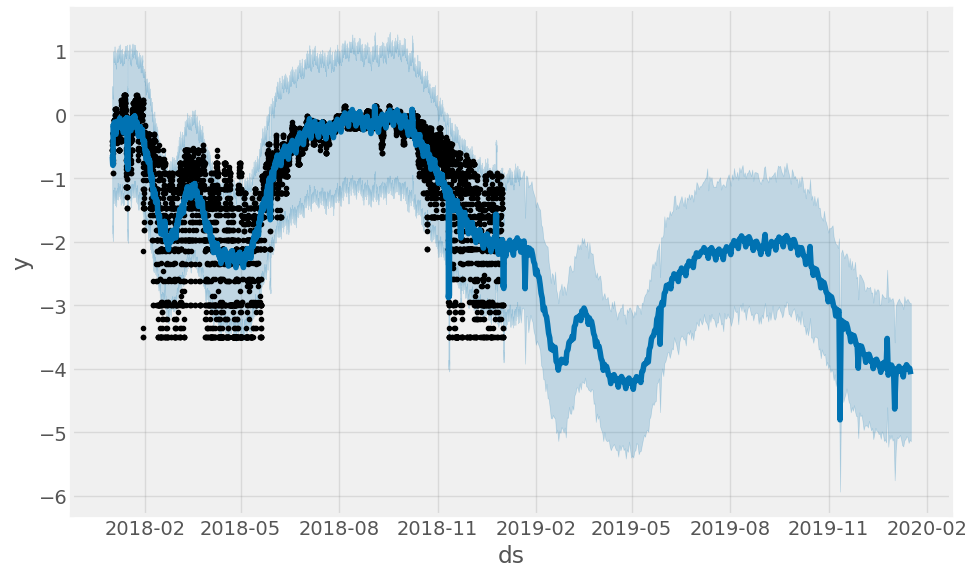

In [5]:
m = Prophet(changepoint_prior_scale=0.011,yearly_seasonality=True,interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)

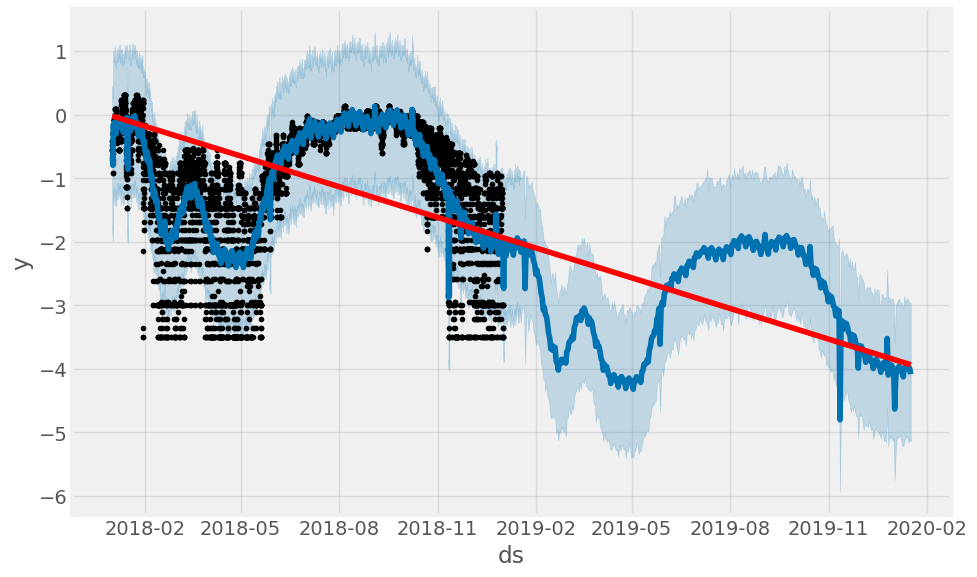

In [6]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [19]:
df = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11], index_col=[0], parse_dates=[0])
df.head()

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [20]:
df = df.rename(columns={df.columns[0]:'y'})
df.head()

,y
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [28]:
df['y'] = np.log(df['y'])
df.head()

,y
timestamp,
2018-01-01 05:00:00,-0.415515
2018-01-01 06:00:00,-0.415515
2018-01-01 07:00:00,-0.486133
2018-01-01 08:00:00,-0.562119
2018-01-01 09:00:00,-0.562119


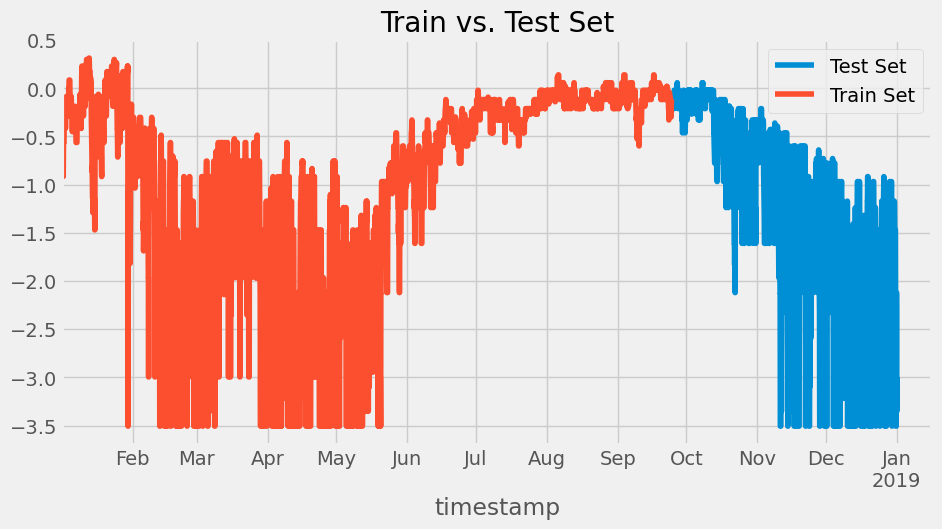

In [29]:
# calculate the split based on percentage
total_rows = len(df)
split_index = int(total_rows * 0.7)  # 70% of the data
split_date = df.index[split_index]

#split_date = 2018-01-01 # enter data manually

train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

test.rename(columns = {'y': 'Test Set'}).join(train.rename(columns = {'y': 'Train Set'}), how = 'outer')\
.plot(figsize = (10,5), title = 'Train vs. Test Set')
plt.show()

In [32]:
train_data = train.reset_index().rename(columns = {'timestamp':'ds'})
test_data = test.reset_index().rename(columns = {'timestamp': 'ds'})

In [33]:
train_data.tail()

,ds,y
6387,2018-09-24 08:00:00,-0.210721
6388,2018-09-24 09:00:00,-0.297732
6389,2018-09-24 10:00:00,-0.238892
6390,2018-09-24 11:00:00,-0.162519
6391,2018-09-24 12:00:00,-0.116534


In [34]:
test_data.head()

,ds,y
0,2018-09-24 13:00:00,-0.116534
1,2018-09-24 14:00:00,-0.116534
2,2018-09-24 15:00:00,-0.116534
3,2018-09-24 16:00:00,-0.116534
4,2018-09-24 17:00:00,-0.116534


In [36]:
m = Prophet(changepoint_prior_scale=0.011,yearly_seasonality=True,interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(train_data)
test_forecast = m.predict(test_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3xbppsub/gkpah_2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3xbppsub/jz6hwf2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57876', 'data', 'file=/tmp/tmp3xbppsub/gkpah_2b.json', 'init=/tmp/tmp3xbppsub/jz6hwf2s.json', 'output', 'file=/tmp/tmp3xbppsub/prophet_modeln5b_hzxj/prophet_model-20230811151307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [100]:
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-09-24 13:00:00,0.686166,0.621578,1.171224,0.686166,0.686166,0.0,0.0,0.0,0.0,...,0.007262,0.007262,0.007262,0.213599,0.213599,0.213599,0.0,0.0,0.0,0.894411
1,2018-09-24 14:00:00,0.686196,0.629461,1.137592,0.686196,0.686196,0.0,0.0,0.0,0.0,...,0.004603,0.004603,0.004603,0.213183,0.213183,0.213183,0.0,0.0,0.0,0.886333
2,2018-09-24 15:00:00,0.686225,0.618595,1.133545,0.686225,0.686225,0.0,0.0,0.0,0.0,...,0.001977,0.001977,0.001977,0.212766,0.212766,0.212766,0.0,0.0,0.0,0.879060
3,2018-09-24 16:00:00,0.686255,0.621192,1.135766,0.686255,0.686255,0.0,0.0,0.0,0.0,...,-0.000591,-0.000591,-0.000591,0.212348,0.212348,0.212348,0.0,0.0,0.0,0.874116
4,2018-09-24 17:00:00,0.686284,0.593711,1.144217,0.686284,0.686284,0.0,0.0,0.0,0.0,...,-0.003080,-0.003080,-0.003080,0.211928,0.211928,0.211928,0.0,0.0,0.0,0.872123


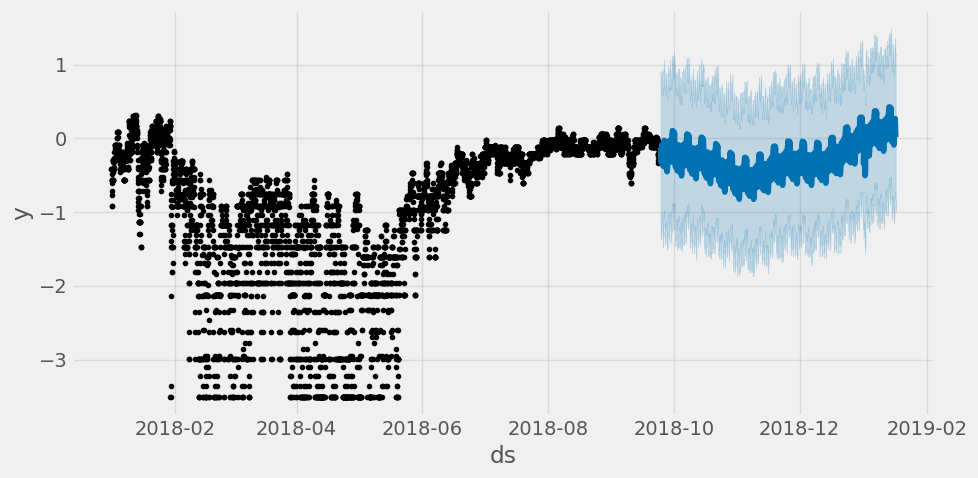

In [37]:
fig, ax = plt.subplots(figsize = (10,5))
fig = m.plot(test_forecast, ax = ax)
ax.set_title = ('Forecast')
plt.show()

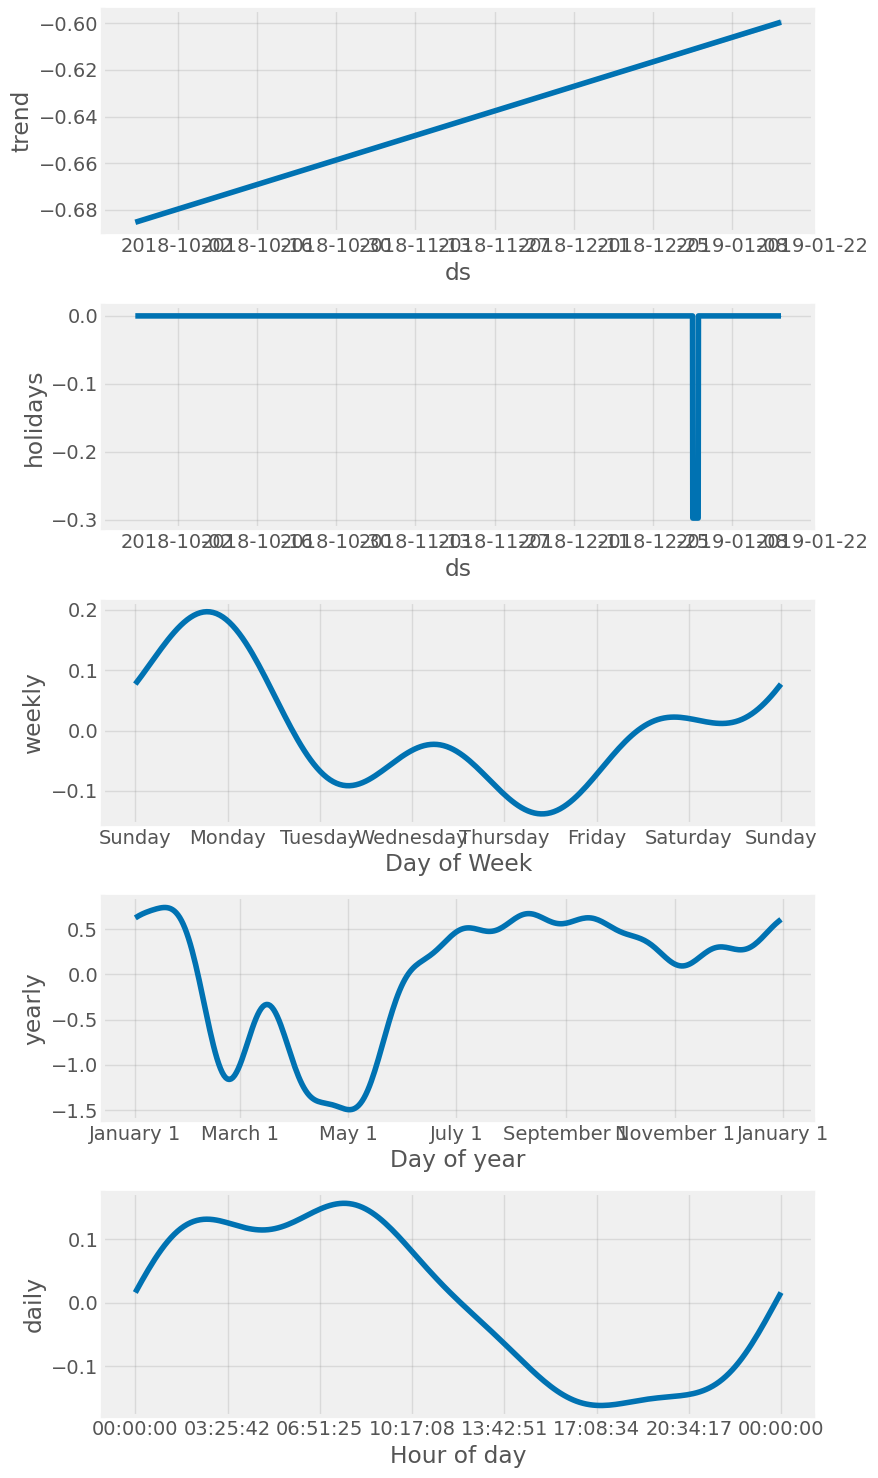

In [38]:
fig = m.plot_components(test_forecast)
plt.show()

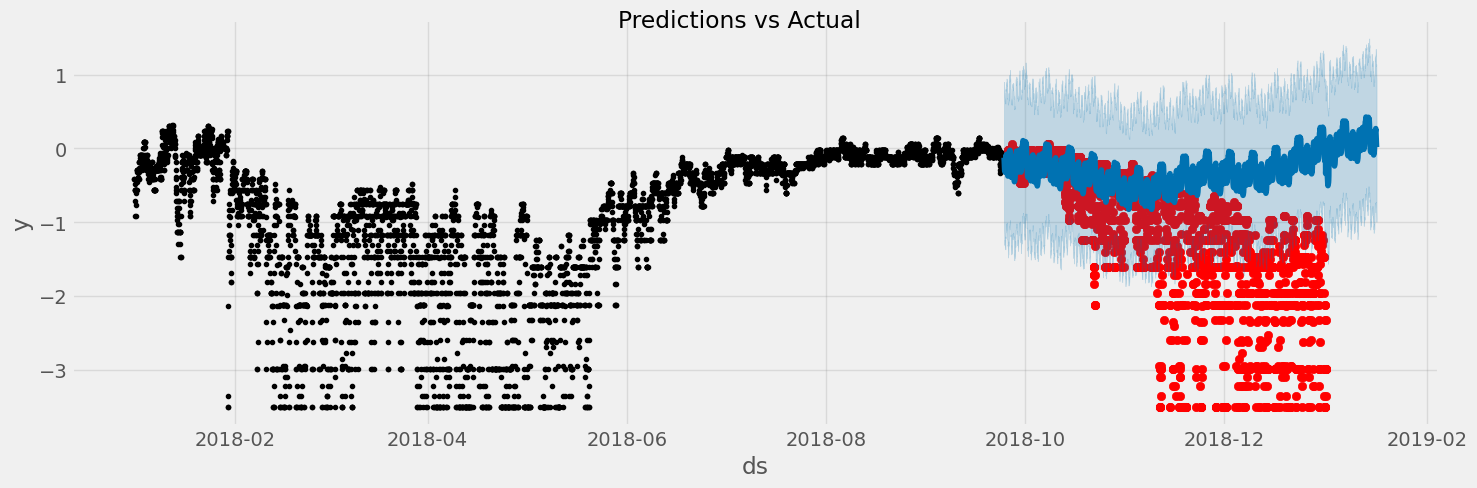

In [41]:
fig, ax = plt.subplots(figsize = (15,5))
ax.scatter(test.index, test['y'], color = 'r')
fig = m.plot(test_forecast, ax=ax)
plot = plt.suptitle('Predictions vs Actual')

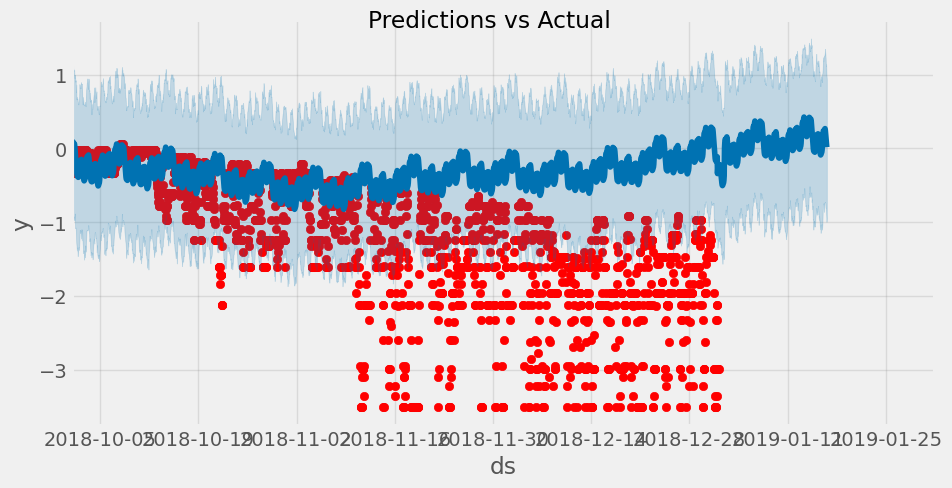

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['y'], color='r')
fig = m.plot(test_forecast, ax=ax)
ax.set_xlim(pd.Timestamp('2018-10-01'), pd.Timestamp('2019-02-01'))
plot = plt.suptitle('Predictions vs Actual')